# Data exploration on PAMI interim dataset
In this notebook we will understand the main features of the dataset and the distribution of the data. We will use the generated interim dataset generated from the raw data, as in this format it will be easier to work with.

## 0.Interim data loading
First we will load the libraries needed to load the interim data and check it is loaded correctly.

In [1]:
import pandas as pd
from pathlib import Path
import os
from src import INTERIM_DATA_DIR, INTERIM_COLUMNS

Now we will load the interim data and check the archives found in the folder. We expect to have three archives: `train.pkl`, `test.pkl` and `validation.pkl`, corresponding to the train, test and validation sets respectively given by the raw data annotations. 

In [2]:
annotations_path = Path(os.path.join(INTERIM_DATA_DIR, 'annotations'))

annotations = {}
for data_split in os.listdir(annotations_path):
    if data_split.endswith('.pkl'):
        file = os.path.join(annotations_path, data_split)
        data_part_name = data_split.split('.')[0]
        annotations[data_part_name] = pd.read_pickle(file)
print("The annotations found are for the datasplits:", list(annotations.keys()))
print(annotations.keys())

The annotations found are for the datasplits: ['test', 'train', 'val']
dict_keys(['test', 'train', 'val'])


We will order them into the following structure: train, validation and test.


In [3]:
# Sort the dictionary based on the order_list
desired_order = ['train', 'val', 'test']
annotations = dict(sorted(annotations.items(), key=lambda x: desired_order.index(x[0])))
print("The annotations order:", list(annotations.keys()))

The annotations order: ['train', 'val', 'test']


The standard column format (further on we will check if it is) for all annotations is:

In [4]:
print("Standard column format:", INTERIM_COLUMNS)

Standard column format: ['path', 'orig_db', 'img_size', 'people', 'bbox', 'label_cat', 'label_cont', 'gender', 'age']


## 1. Emotions analysis and exploration:

First we will compute all the needed metrics for the emotions analysis. Latter on we will analyze each graphic:

In [5]:
import altair as alt 
from itertools import combinations
emotions_per_person = {}
emotion_count = {}
emotion_pairs = []
for data_split in annotations.keys():
    for photo_idx in range(len(annotations[data_split])):
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cat"])):
            emotions = annotations[data_split].loc[photo_idx, "label_cat"][person]
            num_emotions = len(emotions)
            emotion_pairs.extend(list(combinations(emotions, 2)))
            if num_emotions in emotions_per_person.keys():
                emotions_per_person[num_emotions] += 1
            else:
                emotions_per_person[num_emotions] = 1

            for emotion in annotations[data_split].loc[photo_idx, "label_cat"][person]:
                if emotion in emotion_count.keys():
                    emotion_count[emotion] += 1
                else:
                    emotion_count[emotion] = 1

### 1.1. Categorical annotations analysis and exploration

The main goal of this section is to understand the distribution of the categorical annotations in the dataset. We will check the distribution of the annotations in the whole dataset. The annotated categorical annotations are: 

Check know the label category quantity distribution for photos. These are the emotion categories available: 
Now we compute the metrics

#### 1.1.1. Number of emotions felt per each person

Now we analyze the number of emotions per photo:

In [6]:
# Convert dictionary to pandas DataFrame
df = pd.DataFrame(list(emotions_per_person.items()), columns=['Number of emotions', 'Number of people'])

bar_chart = alt.Chart(df).mark_bar(color='steelblue', size=15).encode(
    x='Number of emotions',
    y='Number of people'
).properties(
    title = alt.TitleParams(text = 'Number of emotions felt per each person', fontSize=16),
    width = 300,
    height = 400
)
bar_chart

alt.Chart(...)

We can observe that many people has only one or two emotions per photo, but there are also people with more than 10 emotions per photo. 

#### 1.1.2. Emotions distribution

Now we analyze the occurrence of all the emotions in the dataset:

In [7]:
# Convert dictionary to pandas DataFrame
# Ordenar las claves por valor en orden descendente
sorted_keys = sorted(emotion_count, key=emotion_count.get, reverse=True)
df = pd.DataFrame(list(emotion_count.items()), columns=['Categorical emotion', 'Number of people who felt it'])

bar_chart = alt.Chart(df).mark_bar(color='steelblue', size=15).encode(
    x=alt.X('Categorical emotion:O', sort = sorted_keys, axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Number of people who felt it:Q')
).properties(
    title = alt.TitleParams(text = 'Emotions categories felt across all people', fontSize=16),
    width = 800,
    height = 400
)
bar_chart

alt.Chart(...)

We can observe that the label distribution is not uniform. This is expected, as there are many emotions that has less ocurrences than others. We will need to take care of this when training the model, as it could be biased towards the most common emotions.

We can also observe how the most usual emotion felt is engagement. We will take a closer look, to see the distribution of it to see if it's the only emotion felt or there are more:

In [8]:
emotions_per_person = {} # Dictionary to store the number of emotions per person
selected_emotion = "Engagement" # We focus on the engagement emotion

for data_split in annotations.keys():
    for photo_idx in range(len(annotations[data_split])):
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cat"])):
            emotions = annotations[data_split].loc[photo_idx, "label_cat"][person]
            num_emotions = len(emotions)
            if selected_emotion in emotions: # We filter by the selected emotion we are focusing
                if num_emotions in emotions_per_person.keys():
                    emotions_per_person[num_emotions] += 1
                else:
                    emotions_per_person[num_emotions] = 1

Now we will plot the results:

In [9]:
# Convert dictionary to pandas DataFrame
df = pd.DataFrame(list(emotions_per_person.items()), columns=['Number of emotions', 'Number of people'])

bar_chart = alt.Chart(df).mark_bar(color='steelblue', size=15).encode(
    x='Number of emotions',
    y='Number of people'
).properties(
    title = alt.TitleParams(text = 'Number of emotions felt per each person that has \'Engagement\'', fontSize=16),
    width = 300,
    height = 400
)
bar_chart

alt.Chart(...)

We can observe that there are 5000 people that is labeled only as engagement. So we must take this into account when we are training the model and we must be careful with the results. Some data augmentation or label balance techniques could be useful to solve this problem.

#### 1.1.3. Co-occurrence matrix

In [10]:
# Convertir la lista de pares en un DataFrame
df = pd.DataFrame(emotion_pairs, columns=['emotion1', 'emotion2'])

# Obtén los valores únicos en la lista
unique_items = pd.unique(df[['emotion1', 'emotion2']].values.ravel('K'))

# Crea una matriz de ceros
co_occurrence_matrix = pd.DataFrame(0, index=unique_items, columns=unique_items)

# Itera sobre las filas del DataFrame
for index, row in df.iterrows():
    co_occurrence_matrix.loc[row['emotion1'], row['emotion2']] += 1
    co_occurrence_matrix.loc[row['emotion2'], row['emotion1']] += 1

# Convertir la matriz de co-ocurrencia en formato largo
long_format = co_occurrence_matrix.reset_index().melt(id_vars='index', var_name='column', value_name='value')

In [17]:
# Crear una selección interactiva
selection = alt.selection_single()
selection2 = alt.selection_multi(
    fields = ['index','column'],
    empty = 'none' # empty selection matches no points
)
# Crear un gráfico de calor
heatmap = alt.Chart(long_format).mark_rect(stroke='black').encode(
    x=alt.X('index:O', sort='ascending', title = 'Emotion category'),
    y=alt.Y('column:O', sort='ascending', title = 'Emotion category'),
    color=alt.Color('value:Q', scale=alt.Scale(scheme='blues')),  # Paleta de colores 'viridis'
    tooltip=['index', 'column', 'value']
)

# Crear el segundo gráfico de calor
heatmap2 = alt.Chart(long_format).mark_rect().encode(
    x= alt.X('index:O', sort='ascending'),
    y=alt.Y('column:O', sort='ascending'),
    color=alt.condition(
        alt.datum.index == alt.datum.column,  # Condición para las celdas de la diagonal
        alt.value('black'),  # Color si la condición es verdadera
        alt.value('transparent')  # Color si la condición es falsa
    )
)

# Configure text
text = alt.Chart(long_format).mark_text(baseline='middle').encode(
    x= alt.X('index:O', sort='ascending'),
    y=alt.Y('column:O', sort='ascending'),
    text = 'value:Q',
    color = alt.value ("black"),
    opacity = alt.condition(selection2, alt.value(1),alt.value(0))
)


coocurrence_plot = heatmap + heatmap2 + text
coocurrence_plot.properties(
    title = alt.TitleParams(text = 'Co-occurrence of emotions', fontSize=16),
    width = 800,
    height = 800
).add_selection(
    selection,
    selection2
)

c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\vegalite\v5\api.py:387: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.LayerChart(...)

Now we normalize each row of the co-occurrence matrix to see the the conditioned probability. This will help us to see the probability of each emotion given another emotion.

In [ ]:
# Calcular la suma de cada columna
column_sums = co_occurrence_matrix.sum(axis=0)

# Normalizar cada columna dividiéndola por su suma
normalized_co_occurrence_matrix = co_occurrence_matrix.div(column_sums, axis=1)

# Convertir la matriz de co-ocurrencia en formato largo
long_format = normalized_co_occurrence_matrix.reset_index().melt(id_vars='index', var_name='column', value_name='value')



Now we plot

In [58]:
# Crear una selección interactiva
selection = alt.selection_multi(
    fields = ['column'],
)
selection2 = alt.selection_multi(
    fields = ['column'],
    empty = 'none' # empty selection matches no points
)

tooltip=[
    {'field': 'column', 'title': 'Emotion A'},
    {'field': 'index', 'title': 'Emotion B'},
    {'field': 'value', 'title': 'Conditioned probability B|A'}
]
# Crear un gráfico de calor
heatmap = alt.Chart(long_format).mark_rect(stroke='black').encode(
    x=alt.X('index:O', sort='ascending', title = 'Emotion B'),
    y=alt.Y('column:O', sort='ascending', title = 'Emotion A'),
    color = alt.condition(selection, alt.Color('value:Q',
              title = 'Emotion A conditioned to B probability',
              scale = alt.Scale(scheme='bluegreen'), legend = alt.Legend(titleFontSize = 14, labelFontSize=12)), alt.value('grey')),
    opacity = alt.condition(selection, alt.value(1), alt.Opacity('value:Q')),
    tooltip=tooltip
)

# Crear el segundo gráfico de calor
heatmap2 = alt.Chart(long_format).mark_rect().encode(
    x= alt.X('index:O', sort='ascending'),
    y=alt.Y('column:O', sort='ascending'),
    color=alt.condition(
        alt.datum.index == alt.datum.column,  # Condición para las celdas de la diagonal
        alt.value('black'),  # Color si la condición es verdadera
        alt.value('transparent')  # Color si la condición es falsa
    )
)

# Crear el segundo gráfico de calor
heatmap3 = alt.Chart(long_format).mark_rect().encode(
    x= alt.X('index:O', sort='ascending'),
    y=alt.Y('column:O', sort='ascending'),
    color=alt.condition(
        alt.datum.index == alt.datum.column,  # Condición para las celdas de la diagonal
        alt.value('black'),  # Color si la condición es verdadera
        alt.value('transparent')  # Color si la condición es falsa
    )
)

# Configure text
text = alt.Chart(long_format).mark_text(baseline='middle').encode(
    x= alt.X('index:O', sort='ascending'),
    y=alt.Y('column:O', sort='ascending'),
    text = alt.Text('value:Q', format='.2f'),
    color = alt.value ("black"),
    opacity = alt.condition(selection2, alt.value(1),alt.value(0))
)


coocurrence_plot = heatmap + heatmap2 + heatmap3 + text
coocurrence_plot.properties(
    title = alt.TitleParams(text = 'Probability of appearing the Emotion A conditioned to Emotion B', fontSize=16),
    width = 800,
    height = 800
).add_selection(
    selection,
    selection2
)

c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\vegalite\v5\api.py:387: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.LayerChart(...)

### 1.2. Continuous annotations analysis and exploration



## 2.Main features on the data splits
Here we will check the main features of each data split, such as the number of rows and columns, the data types of the columns and the number of null values. We will also store the insights to then create visualizations to ease the comparison between the splits.

First we load the needed libraries.

In [ ]:
from prettytable import PrettyTable

### 1.1. Data splits main features
Now we show the main features of each split.

In [ ]:
# Dataframe to store the insights
insights_dataframe = []

# Create a table
insight_splits_table = PrettyTable()
# Define column names
insight_splits_table.field_names = ["Data Split","Number of Columns", "Equal to standard columns", "Number of Photos", "Number of People"]


for data_split in annotations.keys():
    # Generate insights
    columns = len(list(annotations[data_split].columns))
    equal_to_standard = list(annotations[data_split].columns) == INTERIM_COLUMNS    
    num_photos = annotations[data_split].shape[0]
    people = sum(annotations[data_split]['people'])
    people_per_photo = round(people/num_photos, 2)

    # Add insights to the table or dataframe
    insight_splits_table.add_row([data_split, columns, equal_to_standard, num_photos, people])
    insights_dataframe.append({'data_split': data_split, 'people_per_photo': people_per_photo, 'num_photos': num_photos})

    
print(insight_splits_table)


+------------+-------------------+---------------------------+------------------+------------------+
| Data Split | Number of Columns | Equal to standard columns | Number of Photos | Number of People |
+------------+-------------------+---------------------------+------------------+------------------+
|   train    |         9         |            True           |      17077       |      23706       |
|    val     |         9         |            True           |       2088       |       3334       |
|    test    |         9         |            True           |       4389       |       7280       |
+------------+-------------------+---------------------------+------------------+------------------+


here we can 

In [ ]:
data = pd.DataFrame(insights_dataframe)

# Ratio people per photo ----------------------------
# Create dot plot
dot_chart = alt.Chart(data).mark_circle(size=100, color='#FF3333', opacity = 1.0).encode(
    x=alt.X('people_per_photo:Q',  scale=alt.Scale(reverse=True), axis = alt.Axis(title = 'People per photo', titleFontSize = 14,)),
    y=alt.Y('data_split:O', sort = desired_order).title('')
).properties(
    title = alt.TitleParams(text = 'Ratio of people apearing in each photo', anchor='middle', fontSize=16, dy=-10),
    width = 600,
    height = 150
)
# Add connecting lines (lollipop stems)
stem_chart = alt.Chart(data).mark_rule(color='#FF9999').encode(
    x=alt.X('people_per_photo:Q',  scale=alt.Scale(reverse = True)),
    y=alt.Y('data_split:O', sort = desired_order, axis = None)
)
# Combine the two charts
lollipop_people_per_photo = (stem_chart + dot_chart)

# Number of photos ----------------------------
# Create dot plot
dot_chart2 = alt.Chart(data).mark_circle(size=100, color='steelblue', opacity = 1.0).encode(
    x=alt.X('num_photos:Q', axis = alt.Axis(title = 'Total photos', titleFontSize = 14,)),
    y=alt.Y('data_split:O', sort = desired_order, 
            axis = alt.Axis(labelPadding = 35, labelAlign = alt.Align('center'), labelFontSize=12, 
                            title ='Data split',  titleBaseline="line-top", titleY = -3, titleX=-70, 
                            titleAngle = 0,  titleFontSize = 14, titleAlign= alt.Align('left')))
).properties(
    title = alt.TitleParams(text = 'Number of photos in data splits', anchor='middle', fontSize=16, dy=-10),
    width = 600,
    height = 150
)
# Add connecting lines (lollipop stems)
stem_chart2 = alt.Chart(data).mark_rule(color='#87CEEB', opacity = 1.0).encode(
    x=alt.X('num_photos:Q'),
    y=alt.Y('data_split:O', sort = desired_order)
)
# Combine the two charts
lollipop_number_photos = stem_chart2 + dot_chart2

# Concatenate the lollipop chart and bar chart horizontally
combined_chart = alt.hconcat(lollipop_people_per_photo, lollipop_number_photos).configure_concat(
    spacing=5
).properties(
    title=alt.TitleParams(text = "Data photo and people insights per each data split", anchor='middle', fontSize=20, dy=-20),
)
combined_chart

alt.HConcatChart(...)

We can observe that the ratio of people is very similar, having most in the test set, followed by the validation and train sets. This is expected as the test set is the hardest one. 

## Checks on the given image information
To ease the analysis we will focus on the training datasplit. We will check the number of images in the training set and the number of images with and without annotations. We will also check the number of images with and without annotations for each class.

First we load the needed libraries.

In [ ]:
from src.visualization.display_img_annot import display_img_annot

### Check the labels for each photo

For this we will take an examples of the train set and check the labels for each photo. Each photo is encoded in BGR instead on RGB, so we will need to convert it to RGB to visualize it correctly.

Regarding the continious labels, we need to remember that valence tells how good or bad the person is feeling (0 to 10), while arousal tells how calm or excited the person is feeling (0 to 10) and dominance tells how much control the person feels they have (0 to 10).

The path of the example image is: C:\Users\arman\Desktop\emotion_recognition\data\interim\images\mscoco\COCO_train2014_000000288841.jpg
There is a total of 1 annotated people in the image


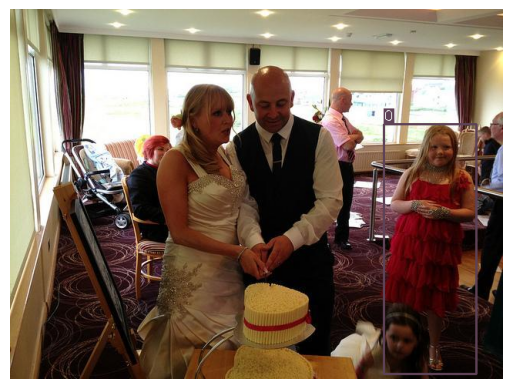

+--------+--------+-----+---------------------+-------------------------------------------------+
| Person | Gender | Age | Emotions categories | Continious emotions (Valence,Arousal,Dominance) |
+--------+--------+-----+---------------------+-------------------------------------------------+
|   0    |   M    |  A  |   ['Anticipation']  |                    [6, 4, 7]                    |
+--------+--------+-----+---------------------+-------------------------------------------------+


In [ ]:
image_id = 1    # The id of the image to be displayed
row_example = annotations['train'].iloc[image_id]
display_img_annot(row_example)

The path of the example image is: C:\Users\arman\Desktop\emotion_recognition\data\interim\images\framesdb\frame_erwzk3npaleubsqm.jpg
There is a total of 3 annotated people in the image


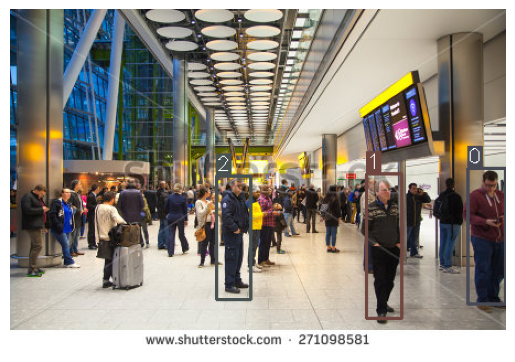

+--------+--------+-----+---------------------+-------------------------------------------------+
| Person | Gender | Age | Emotions categories | Continious emotions (Valence,Arousal,Dominance) |
+--------+--------+-----+---------------------+-------------------------------------------------+
|   0    |   M    |  A  |    ['Engagement']   |                    [7, 2, 9]                    |
|   1    |   M    |  A  |    ['Annoyance']    |                    [6, 4, 7]                    |
|   2    |   M    |  A  |    ['Engagement']   |                    [5, 6, 5]                    |
+--------+--------+-----+---------------------+-------------------------------------------------+


In [ ]:
image_id = 33    # The id of the image to be displayed
row_example = annotations['train'].iloc[image_id]
display_img_annot(row_example)

## Statistics on the annotations


## 3. Sanity checks
We will look for NAN values. We will check if there are any in the dataset.